In [2]:
import numpy as np
import pandas as pd
import random
import glob
import tqdm
from collections import Counter

from utils import metadataUtils
from utils.matrixUtils import plot_confusion_matrix, model_predict
from utils.utils import oversampling
from utils.standardUtils import get_popularity_score, measure_popularity_score

from model import AMPS
import tensorflow as tf
from keras.callbacks import EarlyStopping

np.random.seed(16)
random.seed(16)
tf.random.set_seed(16)

In [3]:
DATA_CSV = './dataset/YouTube_Shorts_Popularity_Prediction_Dataset.csv'
IMAGE_FEATURE_PATH = './feature/awesome_vid_feature.npy'
TEXT_FEATURE_PATH = './feature/shorts_all_title.npy'
DESCRIPTION_FEATURE_PATH = './feature/shorts_all_vidDes.npy'

# IMAGE_FEATURE_SIZE = 2048
# TEXT_FEATURE_SIZE = 768
# METADATA_SIZE = 8
OUTLIER = 0.2

BATCH_SIZE = 64
NUM_CLASSES = 1
LEARN_RATE = 0.0001 #0.01 * (BATCH_SIZE / 128) #try increasing batch size!
# MOMENTUM = 0.9
EPOCHS = 200
PATIENCE = 10

In [15]:
shorts_df = pd.read_csv(DATA_CSV)
image = np.load(IMAGE_FEATURE_PATH)
text = np.load(TEXT_FEATURE_PATH)
shorts_df.shape, image.shape, text.shape

((13011, 31), (13011, 2048), (13011, 768))

In [16]:
y_vrank = np.load(DESCRIPTION_FEATURE_PATH)
y_lrank = metadataUtils.metadata(shorts_df)

image.shape, text.shape, y_vrank.shape

(13011, 8)


/Volumes/MyPassport/YouTube_Shorts_dataset/utils/metadataUtils.py:112: RuntimeWarning: divide by zero encountered in true_divide
  ver2 = (user_metadata/vid_tags) # [0.36745415] [0.71328627] -> nope
/Volumes/MyPassport/YouTube_Shorts_dataset/utils/metadataUtils.py:112: RuntimeWarning: invalid value encountered in true_divide
  ver2 = (user_metadata/vid_tags) # [0.36745415] [0.71328627] -> nope
/Volumes/MyPassport/YouTube_Shorts_dataset/utils/metadataUtils.py:114: RuntimeWarning: divide by zero encountered in true_divide
  ver4 = (totalVideoCount/totalViewCount) # [16.3042378] [3.55510995e-59] !


((13011, 2048), (13011, 768), (13011, 768))

In [17]:
shorts_df.shape

(13011, 31)

100%|██████████| 13001/13001 [00:17<00:00, 733.69it/s]


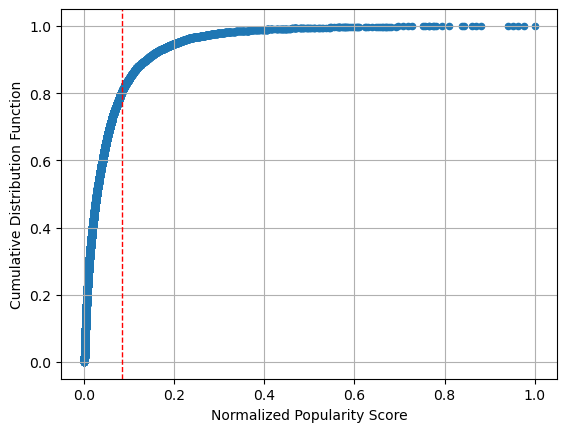

/Volumes/MyPassport/YouTube_Shorts_dataset/utils/standardUtils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shorts_df['popularity'] = 0
/Volumes/MyPassport/YouTube_Shorts_dataset/utils/standardUtils.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shorts_df['popularity'][popular_index] = 1
/Volumes/MyPassport/YouTube_Shorts_dataset/utils/standardUtils.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

((13001, 2048),
 (13001, 768),
 (13001, 768),
 (13001, 8),
 Counter({0: 10946, 1: 2055}))

In [18]:
shorts_df['popularity'] = get_popularity_score(shorts_df)

# remove outlier - In this dataset, we set outlier ratio at 0.2
erase_index = shorts_df[shorts_df['popularity'] >= OUTLIER].index
image = np.delete(image, erase_index, axis=0)
text = np.delete(text, erase_index, axis=0)
y_vrank = np.delete(y_vrank,erase_index, axis=0)
y_lrank = np.delete(y_lrank, erase_index, axis=0)
image.shape, text.shape, y_vrank.shape, y_lrank.shape


shorts_df = measure_popularity_score(shorts_df)

y = shorts_df['popularity']

image.shape, text.shape, y_vrank.shape, y_lrank.shape, Counter(shorts_df['popularity'])

## train valid test split

In [19]:
t = text.shape[0]
test_size = int(round(t*0.1))
train_size = int(round(t*0.8))
valid_size = t-(test_size+train_size)
print("train size:", train_size)
print("valid size:", valid_size)
print("test size:", test_size)

train size: 10401
valid size: 1300
test size: 1300


In [20]:
text.shape, image.shape, y.shape, y_vrank.shape

((13001, 768), (13001, 2048), (13001,), (13001, 768))

In [21]:
shuffle = list(zip(list(y), list(text), list(image), list(y_vrank), list(y_lrank), list(shorts_df.index.values)))
random.shuffle(shuffle)
# print(len(text), len(text[:train_size+valid_size]), len(text[-test_size:]))
text_shuffle_train = []
text_shuffle_valid = []
text_shuffle_test = []
image_shuffle_train = []
image_shuffle_valid = []
image_shuffle_test = []
y_shuffle_train = []
y_shuffle_valid = []
y_shuffle_test = []

y_vrank_shuffle_train = []
y_vrank_shuffle_valid = []
y_vrank_shuffle_test = []
y_lrank_shuffle_train = []
y_lrank_shuffle_valid = []
y_lrank_shuffle_test = []

index_shuffle_test = []
print(len(shuffle))
for _ in range(len(shuffle)):
    if _ < train_size:
        y_shuffle_train.append(shuffle[_][0])
        text_shuffle_train.append(shuffle[_][1])
        image_shuffle_train.append(shuffle[_][2])
        y_vrank_shuffle_train.append(shuffle[_][3])
        y_lrank_shuffle_train.append(shuffle[_][4])
    elif _ < train_size+valid_size:
        y_shuffle_valid.append(shuffle[_][0])
        text_shuffle_valid.append(shuffle[_][1])
        image_shuffle_valid.append(shuffle[_][2])
        y_vrank_shuffle_valid.append(shuffle[_][3])
        y_lrank_shuffle_valid.append(shuffle[_][4])
    else:
        y_shuffle_test.append(shuffle[_][0])
        text_shuffle_test.append(shuffle[_][1])
        image_shuffle_test.append(shuffle[_][2])
        y_vrank_shuffle_test.append(shuffle[_][3])
        y_lrank_shuffle_test.append(shuffle[_][4])
        index_shuffle_test.append(shuffle[_][5])
y_shuffle_train = np.array(y_shuffle_train)
text_shuffle_train = np.array(text_shuffle_train)
image_shuffle_train = np.array(image_shuffle_train)
y_lrank_shuffle_train = np.array(y_lrank_shuffle_train)
y_vrank_shuffle_train = np.array(y_vrank_shuffle_train)

y_shuffle_valid = np.array(y_shuffle_valid)
text_shuffle_valid = np.array(text_shuffle_valid)
image_shuffle_valid = np.array(image_shuffle_valid)
y_lrank_shuffle_valid = np.array(y_lrank_shuffle_valid)
y_vrank_shuffle_valid = np.array(y_vrank_shuffle_valid)

y_shuffle_test = np.array(y_shuffle_test)
text_shuffle_test = np.array(text_shuffle_test)
image_shuffle_test = np.array(image_shuffle_test)
y_lrank_shuffle_test = np.array(y_lrank_shuffle_test)
y_vrank_shuffle_test = np.array(y_vrank_shuffle_test)

y_shuffle_train.shape, y_shuffle_valid.shape, y_shuffle_test.shape
text_shuffle_train.shape, image_shuffle_train.shape, y_lrank_shuffle_train.shape, y_lrank_shuffle_train.shape, len(index_shuffle_test)

13001


((10401, 768), (10401, 2048), (10401, 8), (10401, 8), 1300)

In [22]:
Counter(y_shuffle_train), Counter(y_shuffle_valid), Counter(y_shuffle_test)

(Counter({0: 8761, 1: 1640}),
 Counter({1: 198, 0: 1102}),
 Counter({0: 1083, 1: 217}))

In [23]:
# Imbalance data -> Oversampling

text_shuffle_train,image_shuffle_train,\
    y_vrank_shuffle_train,y_lrank_shuffle_train,y_shuffle_train = oversampling(text_shuffle_train,image_shuffle_train,y_vrank_shuffle_train,y_lrank_shuffle_train,y_shuffle_train)

Counter(y_shuffle_train), Counter(y_shuffle_valid), Counter(y_shuffle_test)

(Counter({0: 8761, 1: 8761}),
 Counter({1: 198, 0: 1102}),
 Counter({0: 1083, 1: 217}))

## Model Training

In [12]:
model = AMPS(NUM_CLASSES,LEARN_RATE)
es = EarlyStopping('val_T1_loss',patience=PATIENCE)

hist=model.fit([image_shuffle_train,text_shuffle_train,y_vrank_shuffle_train,y_lrank_shuffle_train],y_shuffle_train, steps_per_epoch = image_shuffle_train.shape[0] // BATCH_SIZE, \
           epochs = EPOCHS, validation_data=([image_shuffle_valid,text_shuffle_valid,y_vrank_shuffle_valid,y_lrank_shuffle_valid], y_shuffle_valid),\
           validation_steps = image_shuffle_valid.shape[0] // BATCH_SIZE, batch_size = BATCH_SIZE, callbacks = [es])

/Users/minhwa/Desktop/skku/workspace/.conda/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/Users/minhwa/Desktop/skku/workspace/.conda/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/200
274/274 [==============================] - 15s 17ms/step - loss: 0.4510 - T1_loss: 0.2113 - T2_loss: 0.2397 - T1_accuracy: 0.5001 - T2_mse: 0.2397 - T2_mae: 0.4831 - val_loss: 0.4922 - val_T1_loss: 0.2637 - val_T2_loss: 0.2285 - val_T1_accuracy: 0.1609 - val_T2_mse: 0.2285 - val_T2_mae: 0.4649
Epoch 2/200
274/274 [==============================] - 2s 9ms/step - loss: 0.4052 - T1_loss: 0.1846 - T2_loss: 0.2206 - T1_accuracy: 0.5057 - T2_mse: 0.2206 - T2_mae: 0.4478 - val_loss: 0.4130 - val_T1_loss: 0.2053 - val_T2_loss: 0.2077 - val_T1_accuracy: 0.2219 - val_T2_mse: 0.2077 - val_T2_mae: 0.4211
Epoch 3/200
274/274 [==============================] - 2s 8ms/step - loss: 0.3793 - T1_loss: 0.1740 - T2_loss: 0.2053 - T1_accuracy: 0.5312 - T2_mse: 0.2053 - T2_mae: 0.4157 - val_loss: 0.4084 - val_T1_loss: 0.1838 - val_T2_loss: 0.2246 - val_T1_accuracy: 0.3055 - val_T2_mse: 0.2246 - val_T2_mae: 0.4310
Epoch 4/200
274/274 [==============================] - 2s 7ms/step - loss: 0.3665 -

## Test about test set

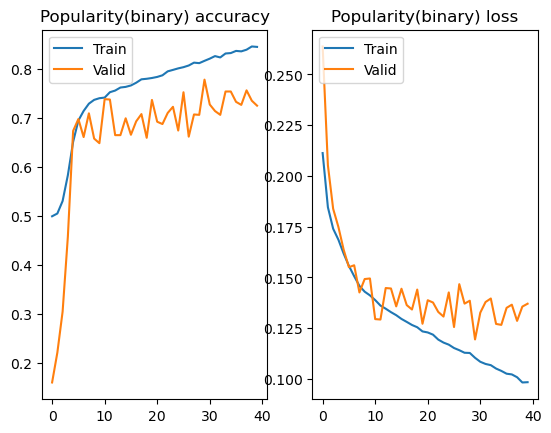

41/41 [==============================] - 2s 2ms/step
Train label 비율) non-popular: 8771 , popular: 8771
Valid label 비율) non-popular: 1092 , popular: 208
Test label 비율) non-popular: 1083 , popular: 217

confusion matrix: 
[[795 288]
 [ 79 138]]
              precision    recall  f1-score   support

 non-popular      0.910     0.734     0.812      1083
     popular      0.324     0.636     0.429       217

    accuracy                          0.718      1300
   macro avg      0.617     0.685     0.621      1300
weighted avg      0.812     0.718     0.748      1300

G-Mean score:  0.6832490118907157
Imbalanced metrics: 
                   pre       rec       spe        f1       geo       iba       sup

non-popular      0.910     0.734     0.636     0.812     0.683     0.471      1083
    popular      0.324     0.636     0.734     0.429     0.683     0.462       217

avg / total      0.812     0.718     0.652     0.748     0.683     0.470      1300



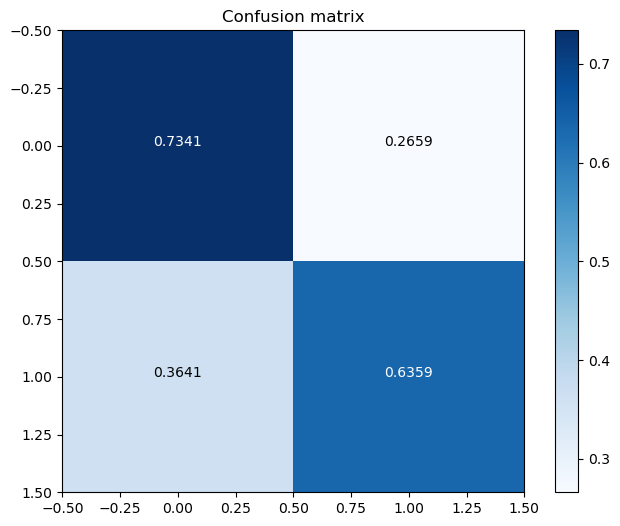

In [13]:
model_predict(model, hist, y_shuffle_train, y_shuffle_valid, y_shuffle_test, \
                  image_shuffle_test,text_shuffle_test,y_vrank_shuffle_test,y_lrank_shuffle_test)